#M5 Forecasting

Kaggle's competition M5 Forecasting - Accuracy dataset consist of Walmart's sales dataset across their shops in 3 states of America. In this notebook we will try to predict sales for 28 days.

##Model

Facebook's Prophet will be model of our choice.
- easy to use without expert knowledge on statistics or time series forecasting
- allows to use multiple seasonabilities 
- easy to input holiday effects

##Objectives
- inspect and analyse provided datasets
- extract holiday from calendar and use it within our model
- train our model and predict future 28 days of sales for each item

##Imports

In [1]:
import pandas as pd
import pickle
from tqdm import tqdm

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation , performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:20,.2f}'.format

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


##Variables

By assigning dtypes we can reduce RAM usage for each dataframe.
- `sell_prices` was reduced from 0.94GB to 0.86GB
- `sales_train_val` was reduced from 0.45GB to 0.07GB
- `calendar` dataframe size is only 0.09MB , so we left it untouched



In [2]:
calendar=pd.read_csv('calendar.csv')
sales_train_val=pd.read_csv('sales_train_validation.csv',dtype={f'd_{v}':'int8' for v in range(1,1914)})
#sample_sub=pd.read_csv('/content/drive/My Drive/Reports/m5-forecasting-accuracy/sample_submission.csv')[:30490]
sell_prices=pd.read_csv('sell_prices.csv',dtype={'wm_yr_wk':'int16','sell_price':'float16'})

##Exploring data

In [3]:
sales_train_val

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


sales_train_val is the main dataset we will use. Each row contains `item_id` , deparment, category , `store_id` , `state_id` and over 5 years of sales ( 1913 days ). 

##Holiday

Holiday feature helps us capture seasonability of dataset. With use of `calendar` dataset , we will :

- translate '**wm_yr_wk**' value `11101` into `2011-01-29` for our **sell_price** dataset

- create **holiday** dataset for our Prophet model

In [4]:
calendar.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


Using dictionary comprehension we will extract and order all events with coresponding dates.

In [5]:
holiday_dict = {holidayName:[date for date in calendar.loc[calendar['event_name_1']==holidayName]['date'].values] for holidayName in calendar['event_name_1'].unique()}

In [6]:
holiday_dict

{nan: [],
 'SuperBowl': ['2011-02-06',
  '2012-02-05',
  '2013-02-03',
  '2014-02-02',
  '2015-02-01',
  '2016-02-07'],
 'ValentinesDay': ['2011-02-14',
  '2012-02-14',
  '2013-02-14',
  '2014-02-14',
  '2015-02-14',
  '2016-02-14'],
 'PresidentsDay': ['2011-02-21',
  '2012-02-20',
  '2013-02-18',
  '2014-02-17',
  '2015-02-16',
  '2016-02-15'],
 'LentStart': ['2011-03-09',
  '2012-02-22',
  '2013-02-13',
  '2014-03-05',
  '2015-02-18',
  '2016-02-10'],
 'LentWeek2': ['2011-03-16',
  '2012-02-29',
  '2013-02-20',
  '2014-03-12',
  '2015-02-25',
  '2016-02-17'],
 'StPatricksDay': ['2011-03-17',
  '2012-03-17',
  '2013-03-17',
  '2014-03-17',
  '2015-03-17',
  '2016-03-17'],
 'Purim End': ['2011-03-20',
  '2012-03-08',
  '2013-02-24',
  '2014-03-16',
  '2015-03-05',
  '2016-03-24'],
 'OrthodoxEaster': ['2011-04-24',
  '2012-04-15',
  '2013-05-05',
  '2015-04-12',
  '2016-05-01'],
 'Pesach End': ['2011-04-26',
  '2012-04-14',
  '2013-04-02',
  '2014-04-22',
  '2015-04-11',
  '2016-04-30']

In [7]:
holiday_list=[pd.DataFrame({'holiday':hol_name,'ds':pd.to_datetime(dates)}) for hol_name,dates in holiday_dict.items()]

In [8]:
holiday_list[1]

,holiday,ds
0,SuperBowl,2011-02-06
1,SuperBowl,2012-02-05
2,SuperBowl,2013-02-03
3,SuperBowl,2014-02-02
4,SuperBowl,2015-02-01
5,SuperBowl,2016-02-07


All converted dataframes will be now atatched to main holiday dataframe.

In [9]:
%%time
holiday = pd.DataFrame(columns=['holiday','ds'])
for d in holiday_list:
  holiday = pd.concat([holiday,d])

CPU times: user 24 ms, sys: 2.24 ms, total: 26.3 ms
Wall time: 25.3 ms


In [10]:
#release RAM and remove unececssary variables
del holiday_list
del holiday_dict

In [11]:
holiday

,holiday,ds
0,SuperBowl,2011-02-06
1,SuperBowl,2012-02-05
2,SuperBowl,2013-02-03
3,SuperBowl,2014-02-02
4,SuperBowl,2015-02-01
...,...,...
0,Easter,2012-04-08
1,Easter,2013-03-31
2,Easter,2014-04-20
3,Easter,2015-04-05


##X_train transfomation

`sales_train_val` contains all training values for our model.

One of the best ways to start data transforming is to remove unecessary columns.

In [12]:
%%time
df=sales_train_val.drop(['item_id','dept_id','cat_id','store_id','state_id'],axis=1).set_index(sales_train_val['id'].str[:-11]).T[1:].set_index(calendar['date'][:1913])

cat_list = list(df.columns)
future = pd.DataFrame({'ds':pd.date_range(start='2016-04-25',end='2016-05-23',freq='d')})
column = 'HOBBIES_1_001_CA_1'

#free up memory and remove unecessary variable
del sales_train_val

CPU times: user 3.13 s, sys: 618 ms, total: 3.75 s
Wall time: 3.78 s


By default, Facebook Prophet will include training data in predictions.

However with such a big dataset, every second of computing time is precious. To speed up such a time consuming task we will specify 28 days we want to predict.

In [13]:
future = pd.DataFrame({'ds':pd.date_range(start='2016-04-25',end='2016-05-26')})

##Fit & Predict

By specifying parameters, our model will be more accurate and faster.

- `daily_seasonality=False`,`weekly_seasonality=False`,`yearly_seasonality=True` - specify seasonability
- `uncertainity_samples=0` as we dont need values for yhat_lower and yhat_upper
- `holidays` - seasonability, ability to catch extra high and extra low selling days

In [14]:
%%time
m = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True,uncertainty_samples=0,holidays=holiday)
data = pd.DataFrame({'ds':df[column].index,'y':df[column].values})
m.fit(data)
predicted_values = m.predict(future)['yhat'].values

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
CPU times: user 717 ms, sys: 14 ms, total: 731 ms
Wall time: 738 ms


We have trained and predicted future 28 days of sales for column `HOBBIES_1_001_CA_1`.
But how good are our predicitons ? Cross validation is a good tool to find out accuracy of our model.

Luckily , Prophet comes already with cross validation tool.

In [15]:
df_cross_val = cross_validation(m,initial='1095 days',period='365 days',horizon='20 days' )

INFO:fbprophet:Making 3 forecasts with cutoffs between 2014-04-05 00:00:00 and 2016-04-04 00:00:00


In [16]:
df_cross_val.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-04-06,0.48,0.31,0.31,0,2014-04-05
1,2014-04-07,0.48,-0.37,-0.37,1,2014-04-05
2,2014-04-08,0.48,0.07,0.07,1,2014-04-05
3,2014-04-09,0.48,0.95,0.95,1,2014-04-05
4,2014-04-10,0.48,0.43,0.43,0,2014-04-05


In [17]:
performance_metrics(df_cross_val)

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,coverage
0,2 days,2.17,1.47,1.08,0.00
1,3 days,1.44,1.20,1.00,0.00
2,4 days,1.29,1.13,0.92,0.00
3,5 days,0.21,0.46,0.42,0.00
4,6 days,0.39,0.62,0.52,0.00
5,7 days,0.56,0.75,0.69,0.00
6,8 days,0.37,0.61,0.58,0.00
7,9 days,0.36,0.60,0.57,0.00
8,10 days,0.28,0.53,0.50,0.00
9,11 days,0.20,0.45,0.42,0.00


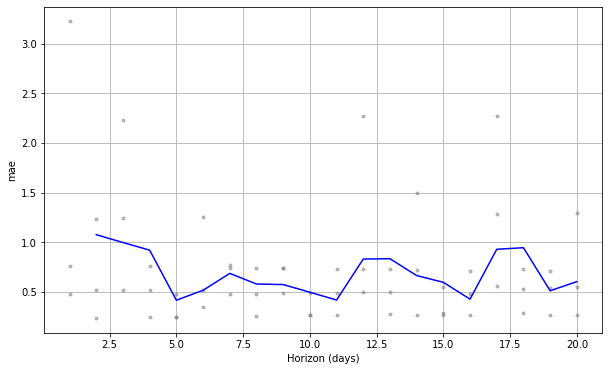

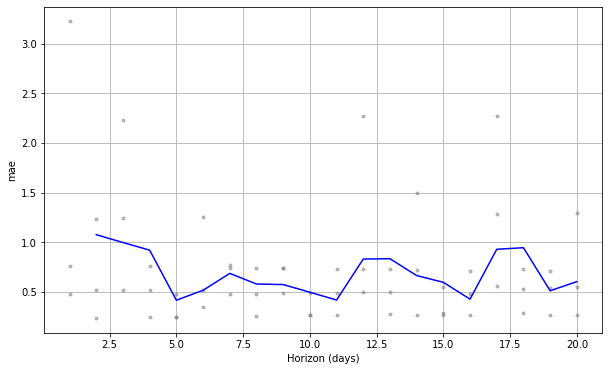

In [18]:
plot_cross_validation_metric(df_cross_val,metric='mae')

Our model is doing pretty well, as `MAE` - mean absolute error is withing appropriate range.

#Fit & Predict 30490 row


In [19]:
%%time
def run_prophet(column):
  m = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True,uncertainty_samples=0,holidays=holiday)
  data = pd.DataFrame({'ds':df[column].index,'y':df[column].values})
  m.fit(data)
  return m.predict(future)['yhat'].values

run_prophet(column)

CPU times: user 775 ms, sys: 10.5 ms, total: 786 ms
Wall time: 792 ms


array([0.811075  , 0.80558623, 0.79965567, 0.79325861, 0.78638292,
       0.72377145, 0.60315429, 0.76297535, 0.7543509 , 0.74540504,
       0.57986303, 0.72685987, 0.71744481, 0.82505171, 0.69885651,
       0.6899107 , 0.68135201, 0.67329498, 0.6658496 , 0.65911866,
       0.65319534, 0.64816097, 0.64408309, 0.64101397, 0.63898935,
       0.63802778, 0.63813026, 0.63928044, 0.64144518, 0.64457558,
       0.64860836, 0.65346762])

Now we have our function that will predict 28 days of sales for given column/item. 

Cell below will use this function to predict 30490 columns/items. On Google's Colabolatory it took over 7 hour to complete. 

To avoid running this cell every single time we run this notebook , I have saved output into pickle file , and commented out whole cell, to prevent it from running.

In [20]:
'''
%%time
out=[]

for n in tqdm(cat_list):
  out.append(run_prophet(n))

import pickle
with open('/content/drive/My Drive/Reports/m5-forecasting-accuracy/prediction.pickle','wb') as pickle_file:
  pickle.dump(out,pickle_file)
'''

"\n%%time\nout=[]\n\nfor n in tqdm(cat_list):\n  out.append(run_prophet(n))\n\nimport pickle\nwith open('/content/drive/My Drive/Reports/m5-forecasting-accuracy/prediction.pickle','wb') as pickle_file:\n  pickle.dump(out,pickle_file)\n"

\[OUT]

100%|██████████| 30490/30490 \[7:08:24<00:00,  1.19it/s]CPU times: user 6h 46min 56s, sys: 21min 52s, total: 7h 8min 49s
Wall time: 7h 8min 24s

Lets load our saved predictions.

In [21]:
predictions=pickle.load(open('predictions.pickle','rb'))

To double check that we have all predicted values, we will use len() function.

In [22]:
len(predictions)

30490

Everything is going according to plan.

#Organise forecast data

As we know , we are still dealing with a large size of data and while designing the fastest function, I have learned a lot about how Pandas and Python work with data. 

##My first attempt:

[IN]
```
%%time
c_names = [f'F{n}' for n in range(1,29)]
final_df = pd.DataFrame(columns=['id']+c_names)
for i in range(len(future_sales)):
  new_row_df = pd.DataFrame(future_sales[i],index=c_names).T
  new_row_df['id']=df.columns[i]
  final_df=pd.concat([final_df,new_row_df])
```
[OUT]


```
CPU times: user 1min 50s, sys: 1.06 s, total: 1min 51s
Wall time: 1min 52s
```

... and improved version :)


In [23]:
%%time
c_names = [f'F{n}' for n in range(1,29)]

forecast = pd.concat([pd.DataFrame(predictions[i],index=c_names).T for i in tqdm(range(len(predictions)))])

forecast['id']=[v for v in df.columns]

100%|██████████| 30490/30490 [00:14<00:00, 2160.28it/s]
CPU times: user 16.3 s, sys: 727 ms, total: 17 s
Wall time: 16.7 s


As we can see , there is always a room for improvement , 17seconds vs almost 2 hours is a massive difference.


We have applied these improvements:
- using list comprehension

- concatenating all dataframes together

In [24]:
forecast

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F20,F21,F22,F23,F24,F25,F26,F27,F28,id
0,0.81,0.81,0.80,0.79,0.79,0.72,0.60,0.76,0.75,0.75,...,0.66,0.65,0.65,0.64,0.64,0.64,0.64,0.64,0.64,HOBBIES_1_001_CA_1
0,0.19,0.20,0.21,0.22,0.23,0.54,0.37,0.28,0.29,0.31,...,0.41,0.41,0.40,0.40,0.39,0.39,0.38,0.37,0.36,HOBBIES_1_002_CA_1
0,0.69,0.69,0.69,0.69,0.69,0.80,0.60,0.69,0.69,0.69,...,0.71,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,HOBBIES_1_003_CA_1
0,1.92,1.91,1.91,1.91,1.90,1.60,3.03,1.90,1.91,1.91,...,2.01,2.02,2.03,2.04,2.05,2.05,2.05,2.05,2.05,HOBBIES_1_004_CA_1
0,0.89,0.86,0.84,0.81,0.79,0.53,0.89,0.74,0.73,0.72,...,0.98,1.03,1.09,1.14,1.20,1.26,1.31,1.36,1.41,HOBBIES_1_005_CA_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.34,0.33,0.33,0.33,0.33,-0.12,-0.09,0.35,0.36,0.37,...,0.41,0.41,0.40,0.39,0.38,0.37,0.36,0.34,0.33,FOODS_3_823_WI_3
0,0.07,0.05,0.02,-0.00,-0.02,0.14,0.30,-0.07,-0.08,-0.09,...,-0.03,-0.02,-0.00,0.01,0.02,0.03,0.04,0.04,0.05,FOODS_3_824_WI_3
0,0.62,0.62,0.62,0.61,0.60,0.80,0.32,0.55,0.53,0.51,...,0.33,0.32,0.32,0.32,0.32,0.33,0.34,0.35,0.36,FOODS_3_825_WI_3
0,1.60,1.61,1.62,1.64,1.65,1.77,1.59,1.68,1.68,1.69,...,1.68,1.67,1.67,1.66,1.66,1.65,1.65,1.65,1.65,FOODS_3_826_WI_3


Now we have organised forecast data, we can attach them to main dataset and visualise our predictions.

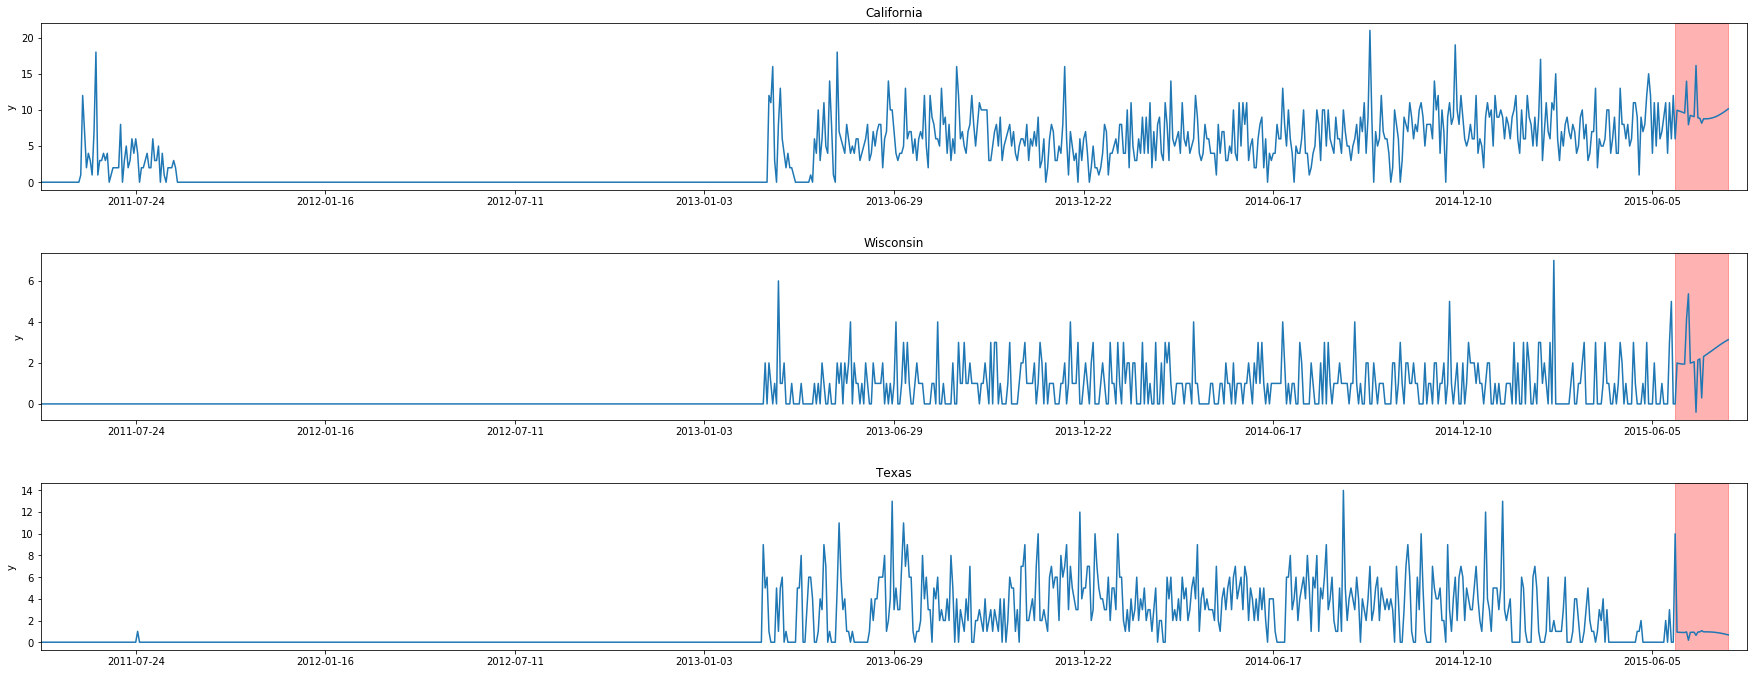

In [26]:
plt.figure(figsize=[25,10])
states = {'CA':'California','WI':'Wisconsin','TX':'Texas'}

for c in range(1,len(states.keys())+1):
  plt.subplot(3,1,c) #position of plot
  plt.xlim(1050,1950) #cut first 1050 days as there were no sales
  state_code = list(states.keys())[c-1] #get state code from states dict

  plt.title(states[state_code]) #set title of plot to state name
  plot_df = pd.DataFrame({'y': list(df[f'HOBBIES_1_354_{state_code}_1'].values.astype('float')) + list(forecast.loc[forecast['id']==f'HOBBIES_1_008_{state_code}_1'][[c for c in forecast.columns if 'F' in c]].values[0])  })
  sns.lineplot(data=plot_df,x=plot_df.index,y='y')
  plt.gca().set(xticklabels = [pd.date_range(start = '2011-01-29', end= '2016-05-26')[int(1941/11*v)].strftime('%Y-%m-%d') for v in range(10)])

  plt.axvspan(1912,1940,alpha=0.3,label='prediction',color='red')
  plt.tight_layout(pad=3.0)
plt.show()

We have sucesfully predicted 28 days of sales for each item in our dataset. 

Analysis comes in separate notebook very soon ... 

Thank you for your attention :)